# Web scraping stage

## Newsapi.org

In [ ]:
%run scraper.py

# Text analytics stage

## Imports

In [102]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None
from collections import Counter
import re
import numpy as np
from functools import reduce

import warnings

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# stop = set(stopwords.words('english'))
from string import punctuation

import nltk
nltk.download('punkt', download_dir='./data/')

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from wordcloud import WordCloud

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to ./data/...
[nltk_data]   Package punkt is already up-to-date!


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## UDFs

The two functions below are borrowed from a <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge"> Kaggle competition </a>.

They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.

In [30]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

Integrate these two functions into a tokenizing function.

In [43]:
def tokenizer(text, stop_words):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

Group the tokens by category, apply a word count and display the top N most frequent tokens. 

In [44]:
def word_count(category, top_n=10):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(top_n)

In [57]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    # plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [99]:
# Define the LDA modeling function that takes the number of topics as a parameter
def LDA_model(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False),
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True)

# Define a metric to assess a good topic model: the coherence score
def compute_coherence(model):
    coherence = CoherenceModel(model=model, 
                           texts=df['tokens_bigram'].values,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

# Vary the number of topics in an interval and pick the number that optimizes the coherence score
def explore_models(topics_df, rg=range(5, 25)):
    id2word = corpora.Dictionary(topics_df['tokens_bigram'])
    texts = topics_df['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model)
        coherences.append(coherence)
      

    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models

# Display topics and corresponding keywords
def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=num_words)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    topics_df = pd.DataFrame(list(topics))
    topics_df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    topics_df.columns = ['keyword_{0}'.format(i) for i in range(1, num_words+1)]
    return topics_df

# Build a document/topic matrix that will be uses for visualization, where a cell i,j contains the probabily of topic j in the document i
def get_document_topic_matrix(corpus, num_topics=best_model.num_topics):
    matrix = []
    for row in tqdm_notebook(corpus):
        output = np.zeros(num_topics)
        doc_proba = best_model[row][0]
        for doc, proba in doc_proba:
            output[doc] = proba
        matrix.append(output)
    matrix = np.array(matrix)
    return matrix

## Load the data

In [32]:
data = pd.read_csv('./data/news.csv')
print(data.shape)
data.head(2)

(462, 9)


,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,http://www.abc.net.au/news/louise--yaxley/5553226,Nationals are urging Barnaby Joyce to deal pri...,2018-06-04T01:53:38Z,abc-news-au,Nationals defend their character after Barnaby...,http://www.abc.net.au/news/2018-06-04/barnaby-...,http://www.abc.net.au/news/image/9830072-16x9-...,general,2018-06-04 11:07:53.129742
1,http://www.abc.net.au/news/sarah-ferguson/6970476,"Felix Sater says he lived a double life, build...",2018-06-03T20:55:11Z,abc-news-au,The business partner Donald Trump wants nothin...,http://www.abc.net.au/news/2018-06-04/felix-sa...,http://www.abc.net.au/news/image/9816150-16x9-...,general,2018-06-04 11:07:53.129742


## Explore

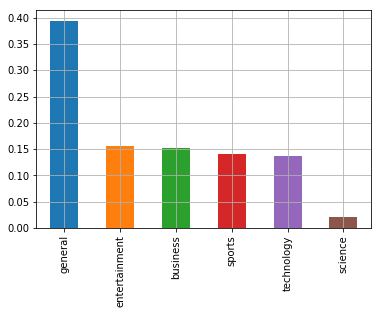

In [33]:
data.category.value_counts(normalize=True).plot(kind='bar', grid=True)
plt.show()

In [34]:
# Remove duplicate description columns
data = data.drop_duplicates('description')

# Remove rows with empty descriptions
data = data[~data['description'].isnull()]
print(data.shape)

(432, 9)


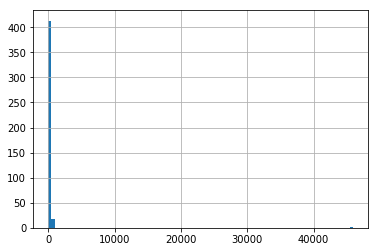

In [35]:
# Distribution of description lengths
data.description.map(len).hist(bins=100);

In [36]:
# Focus on the news articles with descriptions longer than 140 characters
# data = data[(data.description.map(len) > 140)]

data.reset_index(inplace=True, drop=True)
print(data.shape)

(432, 9)


In [37]:
# Sample some news due to memory constraints
data = data.sample(400, random_state=1)
data.reset_index(inplace=True, drop=True)
data.head(2)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,Jason Rowley,Podcasts are television for the earbud generat...,2018-06-03T18:11:13Z,techcrunch,VCs like what they are hearing out of the podc...,https://techcrunch.com/2018/06/03/vcs-like-wha...,https://techcrunch.com/wp-content/themes/techc...,technology,2018-06-04 11:07:53.129742
1,TNW Deals,The shortest distance between two points is a ...,2018-06-01T08:50:13Z,the-next-web,Get Cisco certified with this IT network train...,https://thenextweb.com/offers/2018/06/03/get-c...,https://cdn0.tnwcdn.com/wp-content/blogs.dir/1...,technology,2018-06-04 11:07:53.129742


## Preprocess

In [38]:
data['description'] = data['description'].map(lambda d: str(d))

### Define stopwords

In [39]:
stop_words = []

f = open('./stopwords/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

print(len(stop_words))

668


### Tokenize

Build a tokenizer, which will, for every description, do the following:

- lowercase the text and clean it (separate function)
- break the descriptions into sentences and then break the sentences into tokens
- remove punctuation, stop words

We used to existing stopwords list that includes all stopwords in NLTK and more.

In [42]:
# Apply the tokenizer to each description through all rows
data['tokens'] = data['description'].progress_map(lambda d: tokenizer(d, stop_words))

# Let's check what the tokenization looks like for the first 3 descriptions
for descripition, tokens in zip(data['description'].head(3), data['tokens'].head(3)):
    print('description:', descripition)
    print('tokens:', tokens)
    print() 

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

description: Podcasts are television for the earbud generation. And although many podcasters make money, typically through sponsorships, the podcasting industry (such as it is) hasn’t received much in the way of venture funding -- until quite recently.
tokens: ['podcasts', 'television', 'earbud', 'generation', 'podcasters', 'money', 'typically', 'sponsorships', 'podcasting', 'industry', 'hasn', 'received', 'venture', 'funding']

description: The shortest distance between two points is a straight line. And if you’re looking to break in or advance a career in IT network systems, here’s a straight line scenario for you. ...
tokens: ['shortest', 'distance', 'points', 'straight', 'break', 'advance', 'career', 'network', 'systems', 'straight', 'scenario']

description: Creators of science fiction and fantasy books, films, and TV shows present stories of possible or imaginary worlds – and their presentations can range from the realistic to the fantastical. ...
tokens: ['creators', 'science', 

In [48]:
for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', word_count(category, 10))
    print('---')

category : business
top 10 keywords: [('trump', 12), ('president', 9), ('donald', 9), ('week', 5), ('economic', 4), ('year', 4), ('trade', 4), ('prime', 3), ('market', 3), ('years', 3)]
---
category : technology
top 10 keywords: [('people', 73), ('money', 53), ('time', 27), ('things', 25), ('don', 22), ('hard', 22), ('years', 19), ('investing', 19), ('car', 17), ('financial', 17)]
---
category : entertainment
top 10 keywords: [('year', 4), ('years', 3), ('bring', 3), ('life', 3), ('fans', 2), ('news', 2), ('well', 2), ('broke', 2), ('yesterday', 2), ('early', 2)]
---
category : general
top 10 keywords: [('trump', 32), ('president', 29), ('sunday', 17), ('people', 17), ('year', 15), ('donald', 12), ('guatemala', 10), ('police', 9), ('officials', 8), ('washington', 8)]
---
category : science
top 10 keywords: [('hold', 2), ('cancer', 2), ('brain', 2), ('study', 2), ('half', 2), ('dreams', 2), ('saturn', 1), ('rotating', 1), ('magnetic', 1), ('field', 1)]
---
category : sports
top 10 keywo

Looking at these lists, can we formulate some hypotheses?

### TFIDF

In [51]:
# Create the TFIDF matrix, rows containing documents (descriptions) and columns containing unique terms (tokens) across the documents (descriptions)
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

(400, 168)

In [53]:
# Create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

#### Visualize

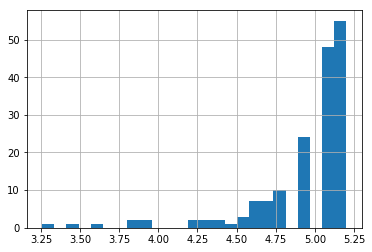

In [55]:
# Distribution of tfidf scores
tfidf.tfidf.hist(bins=25);

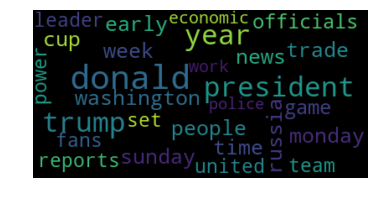

In [58]:
# Display the 30 tokens that have the lowest tfidf scores
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(30))

Not surprisingly, we end up with a list of very generic words (e.g., year, week, economic, sunday, monday etc.). These are very common across many descriptions. tfidf attributes a low score to them as a penalty for not being relevant.

We also notice that Trump, Donald, and president are part of this list for being mentioned in many articles.

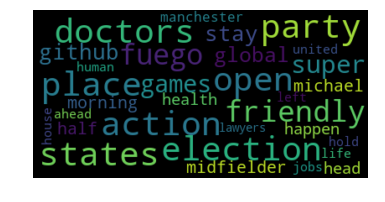

In [59]:
# Now display the 30 words with the highest tfidf scores
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(30))

We end up with less common words. These words naturally carry more meaning for the given description and may outline the underlying topic.

In [69]:
# Use SVD to reduce dimensions to 50
svd = TruncatedSVD(n_components=50, random_state=1)
svd_tfidf = svd.fit_transform(vz)

svd_tfidf.shape

(400, 50)

In [70]:
# Now use t-SNE to reduce dimensions to 2
run = True

if run:
 # run this (takes times)    
    tsne_model = TSNE(n_components=2, verbose=1, random_state=1, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['category'] = data['category']
    tsne_tfidf_df['description'] = data['description']
    tsne_tfidf_df.to_csv('./data/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
    # or import the dataset directly
    tsne_tfidf_df = pd.read_csv('./data/tsne_tfidf.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.511391
[t-SNE] Error after 500 iterations: 0.742372
(400, 2)


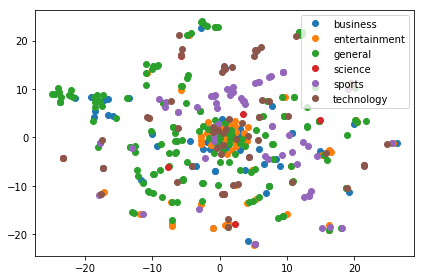

In [71]:
groups = tsne_tfidf_df.groupby('category')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.tight_layout()
plt.show()

We're having two float numbers per discription. This is not interpretable at first sight. What we need to do is find a way to display these points on a plot and also attribute the corresponding description to each point.

In [77]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'category', 'transform': color_map}, 
                   legend='category', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}

show(plot_tfidf)
plt.show()

Loading BokehJS ...

- We see a 2D projection of a high dimensional data. 
- Each dot is a document and the color encodes its category: notice that documents belonging to the general category (green) are scattered all over the plot while those belonging to sports (orange) are close to each other.
- We can also hover on each data point to see the corresponding description and category

## Topic modeling

Our starting point is the tf-idf matrix vz. Let's check its size again.

In [ ]:
vz.shape

This matrix can be seen as a collection of (x) high-dimensional vectors (y). Some algorithms like K-means can crunch this data structure and produce blocks of similar or "close" data points based on some similarity measure like the euclidean distance.

Kmeans needs the number of cluster as parameter. This number is usually determined by trying out different values until the result satisfies a given metrics (silhouette score or distorsion)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

We can pick the number of clusters by varying it in a range of possible values and compute the silhouette score and the distorsion at every iteration. The optimal number is the one that maximizes the first and minimizes the second.

In [ ]:
distorsions = []
sil_scores = []
k_max = 80
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vz)
    sil_score = silhouette_score(vz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

![alt text](images/article_2/silhouette_score_and_distorsion_vs_num_clusters.png)

So how to select the optimal number of clusters from these two plots? this is tricky. 
A small number of cluster may not capture enough topics while a large number (that can although maximize the silhouette score) may induce noise. 

I chose 40 for two reasons:

- when you smooth the silhouette score and ignore the values before k = 10 you notice a peak around this value 
- the elbow curve (distorsion) starts to plateau at 40 clusters

40 clusters. This basically means 40 main topics in a two-week period. Given that we have 8 categories of news, this results in an average number of 5 topics per category. 

Of course you'll have much more topics in reality. But these topics we're detecting are the most important. The recurrent ones, the ones that have been relayed many times by the media.

In [ ]:
num_clusters = 40
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

Let's see the five first description and the associated cluster

In [ ]:
for (i, desc),category in zip(enumerate(data.description),data['category']):
    if(i < 5):
        print("Cluster " + str(kmeans_clusters[i]) + ": " + desc + 
              "(distance: " + str(kmeans_distances[i][kmeans_clusters[i]]) + ")")
        print('category: ',category)
        print('---')

This doesn't tell us much. What we need to look up are the "hot" keywords that describe each clusters. 

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

Let's look at some topics, and *try* to summarize them in one sentence based on their keywords:

- topic 0: A spoiler alert about movies (ex.  the walking dead)
- topic 1: The super bowl event
- topic 5: Obamacare plan to provide affordable healthcare
- topic 7: British Football (Manchester United) and Zlatan
- topic 18: La La Land movie release and the Oscar ceremony
- topic 30: French political news about François Fillion (ex. french minister) and the presidential elections
- topic 33: Oscar nominations
- topic 36: News about the Brexit

Looking at these clusters you can roughly have an idea of what's going on.

Let's plot them, to have an interactive view.

In [ ]:
run = False
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_kmeans = tsne_model.fit_transform(svd_kmeans)
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = kmeans_clusters
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
    kmeans_df['description'] = data['description']
    kmeans_df['category'] = data['category']
    kmeans_df.to_csv('./data/tsne_kmeans.csv', index=False, encoding='utf-8')
else:
    kmeans_df = pd.read_csv('./data/tsne_kmeans.csv')
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)

In [ ]:
reset_output()
output_notebook()
plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][20] + d3['Category20b'][20] 
color_map = bmo.CategoricalColorMapper(factors=kmeans_df['cluster'].unique(), palette=palette)

plot_kmeans.scatter('x', 'y', source=kmeans_df, 
                    color={'field': 'cluster', 'transform': color_map}, 
                    legend='cluster')
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "cluster": "@cluster", "category": "@category"}

show(plot_kmeans)

It looks that there is a dominant cluster scattered all over the space: this is mainly due to the general category of news. 

By hovering on each point you can see the corresponding description. At first sight you could notice that they deal approximately with the same topic. This is coherent since we build our clusters using similarities between relevant keywords.

You can look up a topic in the dataframe above (based on its keywords), and switch to this plot and see the corresponding articles.

Kmeans separates the documents into disjoint clusters. the assumption is that each cluster is attributed a single topic.

However, descriptions may in reality be characterized by a "mixture" of topics. For example, let's take an article that deals with the hearing that Zuckerberg had in front of the congress: you'll obviously have different topics rising based on the keywords: Privacy, Technology, Facebook app, data, etc.

We'll cover how to deal with this problem with the LDA algorithm.

### LDS (Latent Dirichlet Allocation)

Kmeans separates the documents into disjoint clusters under the assumption that each cluster corresponds to a single topic. However, documents may in reality be characterized by a mixture of topics. This problem is dealt with by the LDA (Latent Dirichlet Allocation) algorithm.

LDA considers two things:

- Each document in a corpus is a weighted combination of several topics 
- Each topic has its collection of representative keywords

Ultimately, these are two probability distributions that the algorithm tries to approximate, starting from a random initialization until convergence:

1. For a given document, what is the distribution of topics that describe it?
2. For a given topic, what is the distribution of its words. Put differently, what is the importance of each word in defining the topic nature? 

The main hyperparameter that we have to set correctly in LDA models is the number of topics.

Given the number of topics, LDA starts shuffling the topic distribution in each document and the word distribution in each topic until the final results shows a high segregation of topics.

In [79]:
# Create a corpus and a dictionary using bigram tokens
df = data.copy()

bigram = gensim.models.Phrases(df['tokens'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
df['tokens_bigram'] = df['tokens'].progress_map(lambda tokens: bigram_mod[tokens])

id2word = corpora.Dictionary(df['tokens_bigram'])
texts = df['tokens_bigram'].values
corpus = [id2word.doc2bow(text) for text in texts]

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

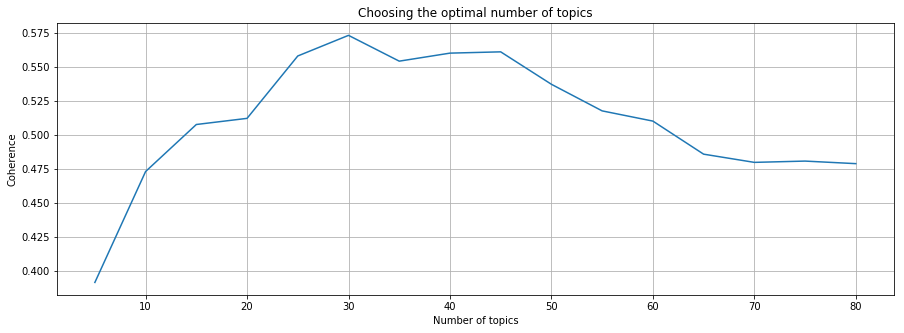

In [82]:
coherences, models = explore_models(df, rg=range(5, 85, 5))

30 seems to be a good number of topics.

In [83]:
best_model = LDA_model(num_topics=30, passes=5)

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

In [98]:
# Display the top 10 keywords for each of these topics
display_topics(best_model, 10)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,news,years,striker,liverpool,cup,offer,intelligence,gains,earned,smaller
topic_1,table,hands,obama,piece,bottom,families,people,heard,class,github
topic_2,help,video,michael,huge,weeks,learn,general,debt,year,joel
topic_3,trump,special,counsel,clear,robert,attorney,mueller,main,grand,appeal
topic_4,cut,president,big,amazon,trump,inside,month,america,easy,kim_jong
topic_5,year,trump,president_donald,economists,top,business,growth,dreams,congress,percent
topic_6,year,fund,neymar,wwdc,capital,super,season,trade,star,brazil
topic_7,time,war,apple,monday,top,beijing,customers,trade,offers,annual
topic_8,president,early,russia,action,office,driving,games,donald_trump,vehicles,netflix
topic_9,sunday,hold,workers,charity,ahead,second,agent,manafort,players,international


#### Visualize

In [103]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_model, corpus, id2word)

In [104]:
pyLDAvis.save_html(panel, './plots/pyLDAvis.html')

# References

- https://newsapi.org/
- http://pythonhosted.org/lda/
- <a href="http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=3&lambda=0.87&term=">NLP post </a>
- <a href="https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/"> Topic Modeling python - sklearn</a>
- <a href="https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/"> Topic Modeling python - gensim</a>
- https://github.com/ahmedbesbes/How-to-mine-newsfeed-data-and-extract-interactive-insights-in-Python
- https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html